In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
from scipy import stats
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


#### 
import nltk
# to trzeba ściągnąć, w cmd:
# >>> import nltk
# >>> nltk.download()
# For central installation, set this to C:\nltk_data

import itertools
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# transformatory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# estymator
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

# splitter
from sklearn.model_selection import train_test_split

# pipeline
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

# metryki
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## Przygotowanie danych tekstowych

In [85]:
def remove_puncation(text):
    cleaned = ''.join([word for word in text if word not in string.punctuation])
    return cleaned

In [86]:
def tokenize(text):

    # Usunięcie wielkich liter
    clean_text = text.lower()

    # Tokenizacja
    tokenized_text = nltk.word_tokenize(clean_text)
    return tokenized_text

In [87]:
stopwords = nltk.corpus.stopwords.words('english')

In [88]:
def remove_stopwords(text):
    without_stopwords = [word for word in text if word not in stopwords]
    return without_stopwords

In [89]:
stemmer = nltk.PorterStemmer()

def stemming(text):
    stemmed_words = [stemmer.stem(word) for word in text]
    return stemmed_words

In [90]:
lemmatter = nltk.WordNetLemmatizer()
def lemmatizing(text):
    lemmatized_words = [lemmatter.lemmatize(word) for word in text]
    return lemmatized_words

### Surowe dane

In [91]:
spam_dataset = pd.read_csv('spam.csv', encoding = "ISO-8859-1", usecols=[0, 1], names=['Spam', 'Text'],
                           skiprows=1)

In [92]:
spam_dataset['Spam'] = spam_dataset['Spam'].replace(['ham','spam'],[0,1])
spam_dataset['Spam'].value_counts(normalize=True)
spam_dataset['Cleaned_Text'] = spam_dataset['Text'].apply(lambda x: remove_puncation(x))
spam_dataset['Tokenized_Text'] = spam_dataset['Cleaned_Text'].apply(lambda x: tokenize(x))
spam_dataset['WithoutStop_Text'] = spam_dataset['Tokenized_Text'].apply(lambda x: remove_stopwords(x))
spam_dataset['Stemmed_Text'] = spam_dataset['WithoutStop_Text']
spam_dataset['Lemmatized_Text'] = spam_dataset['Stemmed_Text'].apply(lambda x: lemmatizing(x))

In [93]:
data = spam_dataset.drop(['Cleaned_Text', 'Tokenized_Text', 'WithoutStop_Text', 'Stemmed_Text'], axis=1)
data['features'] = data.Lemmatized_Text.apply(lambda x: " ".join(x))

In [94]:
metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score', 'AUC'])
metrics_dataframe
models = []
models_names = []
predictions_proba_list = []

In [95]:
def calculate_metrics(model, name, X_checked, y_checked):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba[:,1])

    ############## metryki dla sprawdzanego modelu ################
    # Precision, Recall, F1, Accuracy
    print(classification_report(y_checked, predictions))

    # Confusion matrix
    plt.figure(figsize=(3,3))
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    # plot ROC curve
    fig = plt.figure(figsize=(3, 3))
    plt.plot([0, 1], [0, 1], 'k--')
    for model_selected, name_selected, pred_proba in zip(models, models_names, predictions_proba_list):
        fpr, tpr, thresholds = roc_curve(y_checked, pred_proba)
        plt.plot(fpr, tpr, label=name_selected)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    f1_metric = f1_score(y_checked, predictions)
    auc_metric = roc_auc_score(y_checked, predictions_proba[:,1])
    # metrics_dataframe = metrics_dataframe.concat({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},
    #                                              ignore_index=True)
    # metrics_dataframe = pd.concat([metrics_dataframe, pd.DataFrame({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric})],
    #                                              ignore_index=True, axis=0)
    new_row = pd.DataFrame({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric}, index=[0])
    metrics_dataframe = pd.concat([metrics_dataframe, new_row])
    return metrics_dataframe

## Uczenie modeli

### Dane wejściowe

In [96]:
X, y = data.features, data.Spam

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42, stratify=y)

### Model wstepny - obliczenie feature importance

#### CountVectorizer()

In [98]:
vectorizer_count = CountVectorizer(min_df=0.01, max_df=0.25, ngram_range=(1,1))
X_train_vectorized = vectorizer_count.fit_transform(X_train)
X_test_vectorized = vectorizer_count.transform(X_test)

classifier_count = RandomForestClassifier(max_depth=2, random_state=42)
classifier_count.fit(X_train_vectorized, y_train)

classifier_count.score(X_train_vectorized, y_train), classifier_count.score(X_test_vectorized, y_test)

(0.8721055465805062, 0.8735199138858988)

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1609
           1       1.00      0.06      0.11       249

    accuracy                           0.87      1858
   macro avg       0.94      0.53      0.52      1858
weighted avg       0.89      0.87      0.82      1858



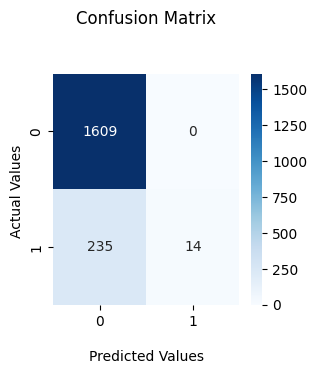

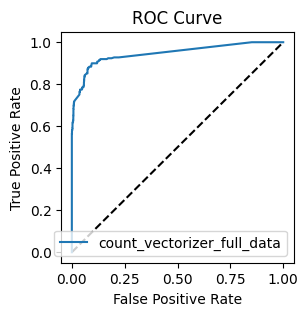

,Model,F1_score,AUC
0,count_vectorizer_full_data,0.106464,0.946378


In [99]:
calculate_metrics(classifier_count, 'count_vectorizer_full_data', X_test_vectorized, y_test)

#### TfidfVectorizer()

In [100]:
vectorizer_tfidf = TfidfVectorizer(min_df=0.01, max_df=0.25, ngram_range=(1,1))
X_train_vectorized = vectorizer_tfidf.fit_transform(X_train)
X_test_vectorized = vectorizer_tfidf.transform(X_test)

classifier_tfidf = RandomForestClassifier(max_depth=2, random_state=42)
classifier_tfidf.fit(X_train_vectorized, y_train)

classifier_tfidf.score(X_train_vectorized, y_train), classifier_tfidf.score(X_test_vectorized, y_test)

(0.8729133010231557, 0.8740581270182992)

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1609
           1       1.00      0.06      0.11       249

    accuracy                           0.87      1858
   macro avg       0.94      0.53      0.52      1858
weighted avg       0.89      0.87      0.82      1858



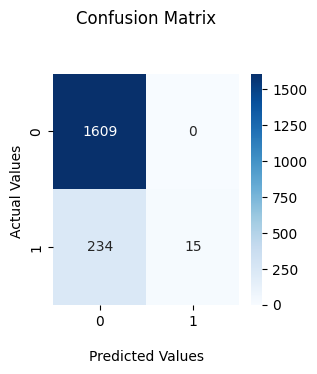

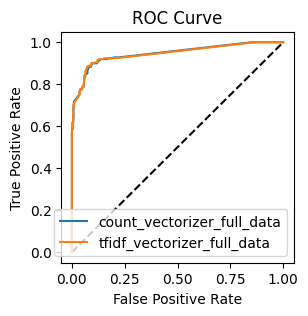

,Model,F1_score,AUC
0,count_vectorizer_full_data,0.106464,0.946378
0,tfidf_vectorizer_full_data,0.113636,0.945400


In [101]:
calculate_metrics(classifier_tfidf, 'tfidf_vectorizer_full_data', X_test_vectorized, y_test)

### Model docelowy

In [102]:
metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score', 'AUC'])
metrics_dataframe
models = []
models_names = []
predictions_proba_list = []

In [103]:
features_to_leave = np.where(classifier_tfidf.feature_importances_>1e-3)
vocabulary_trimmed = dict(zip(list(np.array(list(vectorizer_tfidf.vocabulary_.keys()))[features_to_leave]),
    list(np.array(list(vectorizer_tfidf.vocabulary_.values()))[features_to_leave])))
words_left = list(np.array(list(vectorizer_tfidf.vocabulary_.keys()))[features_to_leave])

In [104]:
data['clean'] = data['Lemmatized_Text'].apply(lambda x: [j for j in x if j in words_left])
data['clean_features'] = data['clean'].apply(lambda x: " ".join(x))
data = data.loc[data['clean_features'] != '']

In [105]:
X, y = data.clean_features, data.Spam
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42, stratify=y)

In [106]:
vectorizer_final = TfidfVectorizer(min_df=0.01, max_df=0.25, ngram_range=(1,1))
# vectorizer_final = CountVectorizer(min_df=0.01, max_df=0.25, ngram_range=(1,1))
X_train_vectorized = vectorizer_final.fit_transform(X_train)
X_test_vectorized = vectorizer_final.transform(X_test)

classifier_final = RandomForestClassifier(max_depth=2, random_state=42)
classifier_final.fit(X_train_vectorized, y_train)

classifier_final.score(X_train_vectorized, y_train), classifier_final.score(X_test_vectorized, y_test)

(0.8460166468489893, 0.8406658739595719)

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       687
           1       1.00      0.13      0.23       154

    accuracy                           0.84       841
   macro avg       0.92      0.56      0.57       841
weighted avg       0.87      0.84      0.79       841



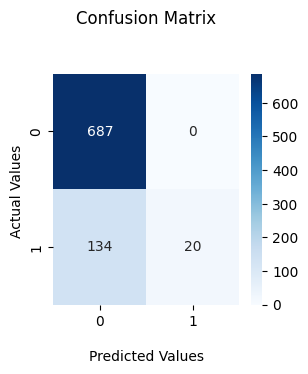

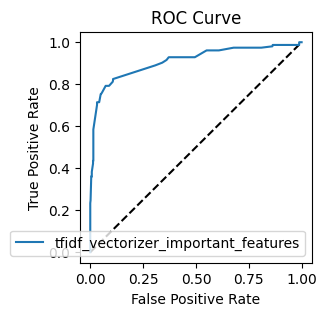

,Model,F1_score,AUC
0,tfidf_vectorizer_important_features,0.229885,0.909927


In [107]:
calculate_metrics(classifier_final, 'tfidf_vectorizer_important_features', X_test_vectorized, y_test)


docelowy Pipeline

In [108]:
cv = KFold(n_splits=5, shuffle=False)

# transformer = CountVectorizer(min_df=0.01, max_df=0.25, ngram_range=(1,1))
transformer = TfidfVectorizer(min_df=0.01, max_df=0.25, ngram_range=(1,1))
classifier = RandomForestClassifier(max_depth=2, random_state=42)

pipeline = Pipeline(steps=[('transformer', transformer),
                            ('classifier', classifier)])

params = {'transformer__min_df': [0.0001, 0.001, 0.005],
        # 'transformer__max_df': [0.4, 0.5, 0.6, 0.7, 0.8, 0.99, 1.0],
        'transformer__max_df': [0.4, 0.6, 0.8, 0.99, 1.0],
        'transformer__ngram_range': [(1,1),(1,2),(2,2)]}

gridsearch = GridSearchCV(pipeline,
                            params,
                            scoring='f1',
                            cv=cv,
                            n_jobs=-1)
gridsearch.fit(X_train, y_train)
print("\nNajlepsze hiperparametry:", gridsearch.best_params_, "\n")

model_best = gridsearch.best_estimator_


Najlepsze hiperparametry: {'transformer__max_df': 0.4, 'transformer__min_df': 0.0001, 'transformer__ngram_range': (1, 1)} 



              precision    recall  f1-score   support

           0       0.84      1.00      0.91       687
           1       1.00      0.13      0.23       154

    accuracy                           0.84       841
   macro avg       0.92      0.56      0.57       841
weighted avg       0.87      0.84      0.79       841



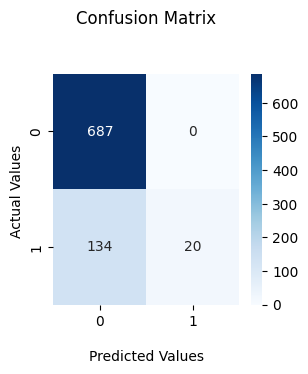

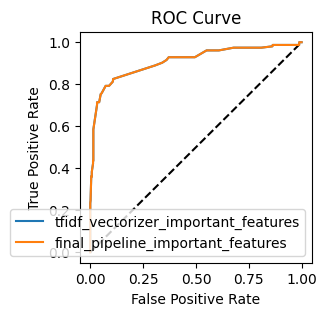

,Model,F1_score,AUC
0,tfidf_vectorizer_important_features,0.229885,0.909927
0,final_pipeline_important_features,0.229885,0.909927


In [109]:
calculate_metrics(model_best, 'final_pipeline_important_features', X_test, y_test)

Model po usunięciu danych o feature_importance <= 10^{-3} osiąga znacznie lepszy f1_score, ale słabsze AUC